In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

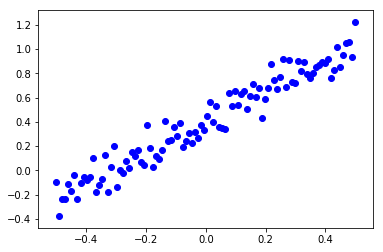

In [21]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32)
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

In [22]:
model = nn.Linear(1,1)

In [23]:
model.weight

Parameter containing:
 0.3510
[torch.FloatTensor of size 1x1]

In [24]:
model.bias

Parameter containing:
-0.9209
[torch.FloatTensor of size 1]

In [25]:
var_result = model.weight + 123

In [26]:
var_result

Variable containing:
 123.3510
[torch.FloatTensor of size 1x1]

In [27]:
var_result.data


 123.3510
[torch.FloatTensor of size 1x1]

In [28]:
model.weight.data


 0.3510
[torch.FloatTensor of size 1x1]

In [29]:
model_y = model(Variable(torch.from_numpy(data_x[:, None]))) 

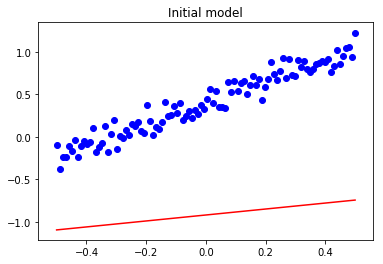

In [30]:
_ = plt.plot(data_x, model_y.data.numpy()[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [31]:
data_y_v = Variable(torch.from_numpy(data_y))
loss_criterion = nn.MSELoss()
loss = loss_criterion(model_y, data_y_v)

In [32]:
loss.backward()

In [33]:
print "dloss/dW : {}".format(model.weight.grad)

SyntaxError: invalid syntax (<ipython-input-33-ec4aec634d9d>, line 1)

In [34]:
type(model(data_x_v))

torch.autograd.variable.Variable

Itr 0 loss: Variable containing:
 1.9189
[torch.FloatTensor of size 1]

Itr 25 loss: Variable containing:
 1.9189
[torch.FloatTensor of size 1]

Itr 50 loss: Variable containing:
 1.9189
[torch.FloatTensor of size 1]

Itr 75 loss: Variable containing:
 1.9189
[torch.FloatTensor of size 1]



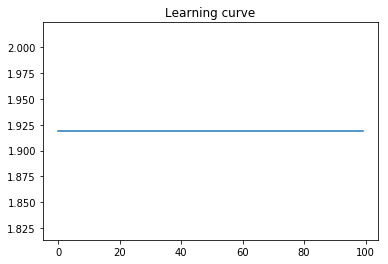

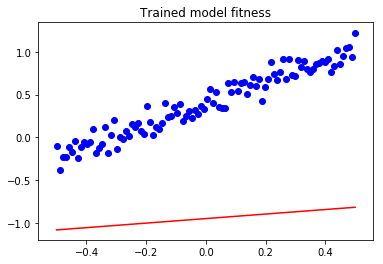

In [35]:
model = nn.Linear(1,1)
losses = []
data_x_v = Variable(torch.from_numpy(data_x[:,None]))
data_y_v = Variable(torch.from_numpy(data_y))

for i in range(100):
    loss = loss_criterion(model(data_x_v),data_y_v)
    losses.append(float(loss.data[0]))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x_v).data.numpy()[:,0], c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")

In [36]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = '/Users/khim/data/'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train = dset.MNIST(root=root, train=True, transform=trans, download=True)
test = dset.MNIST(root=root, train=False, transform=trans)

Processing...
Done!


Reference : https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558

In [38]:
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])

train[i][0] is the ith image that's flattened, and has shape: torch.Size([1, 28, 28])
train[i][1] is the ith image's label, such as: 3


train and test are already FloatTensors

In [39]:
train[12][0].numpy().squeeze(0).shape

(28, 28)

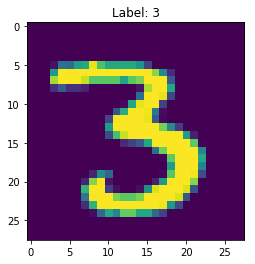

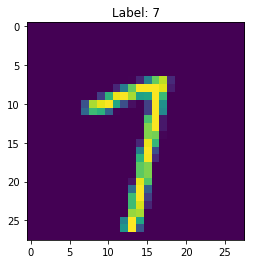

In [40]:
plt.imshow(train[12][0].numpy().squeeze(0))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].numpy().squeeze(0))
_ = plt.title("Label: %s" % train[42][1])

In [41]:
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': False} # pin_memory True for CUDA
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False, **kwargs)

In [42]:
from collections import namedtuple, defaultdict, deque

In [47]:
def run(model, num_epochs=2):
    
    params = model.parameters()
    optimizer = optim.Adam(params)
    loss_criterion = nn.CrossEntropyLoss()
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            xs, ys = Variable(x), Variable(target)
            
            # modify the inputs so that we save the last layer as 28x28
            xs = xs.squeeze(1)
            xs = xs.view(xs.size(0),-1)
            

            logits = model(xs)

            loss = loss_criterion(logits, ys)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx, loss.data[0]))

        correct_cnt, ave_loss = 0, 0
        for batch_idx, (x, target) in enumerate(test_loader):
            x, ys = Variable(x, volatile=True), Variable(target, volatile=True)
            x = x.squeeze(1).view(x.size(0),-1)
            logits = model(x)
            loss = loss_criterion(logits, ys)
            _, pred_label = torch.max(logits.data, 1)
            correct_cnt += (pred_label == ys.data).sum()
            ave_loss += loss.data[0]
        accuracy = correct_cnt*1.0/len(test_loader)/batch_size
        ave_loss /= len(test_loader)
        print ("==>>> epoch: {}, test loss: {:.6f}, accuracy: {:.4f}".format(epoch, ave_loss, accuracy))

# try a simple linear model
run(nn.Linear(784,10))

==>>> epoch: 0, batch index: 0, train loss: 2.387282
==>>> epoch: 0, batch index: 100, train loss: 0.981063
==>>> epoch: 0, batch index: 200, train loss: 0.646500
==>>> epoch: 0, batch index: 300, train loss: 0.359029
==>>> epoch: 0, batch index: 400, train loss: 0.559911
==>>> epoch: 0, batch index: 500, train loss: 0.643133
==>>> epoch: 0, batch index: 600, train loss: 0.253215
==>>> epoch: 0, batch index: 700, train loss: 0.390780
==>>> epoch: 0, batch index: 800, train loss: 0.284990
==>>> epoch: 0, batch index: 900, train loss: 0.444607
==>>> epoch: 0, batch index: 1000, train loss: 0.638693
==>>> epoch: 0, batch index: 1100, train loss: 0.370261
==>>> epoch: 0, batch index: 1200, train loss: 0.182563
==>>> epoch: 0, batch index: 1300, train loss: 0.532880
==>>> epoch: 0, batch index: 1400, train loss: 0.403007
==>>> epoch: 0, batch index: 1500, train loss: 0.428773
==>>> epoch: 0, batch index: 1600, train loss: 0.159999
==>>> epoch: 0, batch index: 1700, train loss: 0.174093
==>>

In [50]:
class MLP(nn.Module):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(28, n_units)  # n_in -> n_units
        self.l2 = nn.Linear(n_units, n_units)  # n_units -> n_units
        self.l3 = nn.Linear(n_units, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return(x)
        
        raise NotImplementedError()
run(MLP(200, 10))

RuntimeError: size mismatch, m1: [32 x 784], m2: [28 x 28] at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:1293